## AIFFEL Exploration 01 가위 바위 보 프로젝트

- 아이펠 강남에 들어와서 처음으로 진행 되었던 Exploration이었고, 이미지 데이터 수집부터 시작해서 데이터를 딥러닝 프레임 워크인 케라스의 모델에 돌려보았던 시간이었다.
- 주변의 지인에게 부탁하여 데이터를 계속 추가하는 작업을 진행하였다. 하지만 예제에서 제시되었던 mnist 데이터셋에 비해 데이터의 양이 상대적으로 적다는 한계가 아쉽지만, 데이터를 __수집, 전처리, 모델학습, 평가__ 를 직접 경험하면서 데이터의 중요함을 배워가는 시간이었다. 순서는 다음과 같다. 

#### 1. 데이터 수집 및 전처리
- 이미지 수집 및 사용된 라이브러리
- resize_images(), load_data() 함수 코드 설명
- 데이터 정규화

#### 2. 모델 구성, 하이퍼 파라미터 튜닝 및 평가
- 베이스모델 설명
- 모델 최적화를 위한 방법
- 하이퍼파라미터 튜닝 결과 및 평가

#### 3. 회고


In [1]:
# 이미지 데이터에 접근하기 위해서 사용하는 라이브러리
import glob
import os

# 데이터 전처리 및 시각화에 쓸 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import seaborn as sns

%matplotlib inline


# 모델을 만들기 위한 프레임 워크
import tensorflow as tf
from tensorflow import keras
from keras.layers import BatchNormalization, Dropout
from keras.utils.np_utils import to_categorical

%pprint

Pretty printing has been turned OFF


#### 1. 데이터 수집 및 전처리

##### 이미지 수집  및 전처리에 사용된 라이브러리
- 구글의 [teachable machine](https://teachablemachine.withgoogle.com/) 웹페이지에 접속해서 웹캠을 이용하여  244 x 244 픽셀 컬러 사진을 수집하였다. 함께 학습하는 5조 조원분들과 이미지를 공유하고, 주변 친구들에게 요청하여서 가위, 바위, 보를 각각 수집하였다. 
![](https://raw.githubusercontent.com/Asunny2019/AIFFEL_Exploration/cde46562817225c4de94778c233b53781a65213d/img/paper_back_7.jpg)
||학습 데이터(train data)|시험데이터(test data)|
|-|-|-|
|총 사진 갯수|3 class x720(장/class) = 2160 장 |3 class x 150(장/class) = 450장|

- 학습 데이터의 손 사진을 찍은 사람과 시험 데이터의 손 사진을 분리하였다.학습데이터에 참여한 사람이 시험 데이터의 이미지에도 넣으면 다른 각도의 이미지이라도 비슷한 손모양이기 때문에 과대평가 될 수 있겠다고 생각해서 이미지를 분리하였다.    

- 처음에는 학습데이터를 1800장 테스트 데이터셋을 총150장으로 작업을 진행하다가 테스트 데이터셋이 너무 적고 다양성이 부족해서 모델 성능을 대표하기에는 부족할 것 같아서 지인들에게 부탁을 해서 테스트 데이터 셋과 훈련 데이터 셋을 추가하였다.

#### 전처리 과정에서 사용된 라이브러리 glob, PIL(pillow),numpy

#### glob.glob(pathname, *, root_dir=None, dir_fd=None, recursive=False) 와 glob.iglob
- glob모듈은 유닉스 셸이 사용하는 규칙에 따라 지정된 패턴과 일치하는 모든 경로명을 찾아준다. 
- 그 중에서 glob.glob 함수는 pathname에 일치하는 경로(절대경로 혹은 상대경로)를 찾아서 리스트로 반환해준다. 경로에 와일드카드(* : 문자열 모두, ?: 문자열 한개 등)를 포함할 수 있고, 와일드 카드에 매칭되는 파일의 경로를 모두 찾아주므로 편리하다. __glob.iglob__ 는 glob.glob와 같은 결과를 제너레이터로 반환하므로 메모리를 절약할 수 있다..

In [2]:
glob_prt=glob.glob( os.getenv("HOME") + '/aiffel/rock_scissor_paper/scissor/*.jpg')
iglob_prt=glob.iglob( os.getenv("HOME") + '/aiffel/rock_scissor_paper')

print("glob.glob 사용시",glob_prt[:1]) # glob.blob는 리스트,
print("glob.iglob 사용시",iglob_prt)   # glob.iglob는 제너레이터를 반환한다.

glob.glob 사용시 ['/aiffel/aiffel/rock_scissor_paper/scissor/CLASS_SCISSORS_KIWEON.ZIP (1)_25.jpg']
glob.iglob 사용시 <generator object _iglob at 0x7f136fdbe5f0>


#### PIL라이브러리의 Image 클래스
- __img=Image.open(path)메서드__: 이미지 파일의 path를 open 메서드의 인자로 입력하면 해당 이미지를 변수 __old_img__ 에 이미지를 반환한다.
- __new_img=img.resize((50,50), Image.ANTIALIAS)__ :변수 __old_img__ 에 있는 이미지의 사이즈를 50,50사이즈로 변경한다. 두번째 인자는 높은 해상도의 사진을 낮은 해상도로 변환할 때 깨지는 패턴의 형태를 최소화해주는 방법으로 안티엘리어싱이라고 한다. 다음 이미지는 엘리어싱 된 이미지와 ANTIALIAS이미지의 차이이다.
![](https://helpx.adobe.com/content/dam/help/en/photoshop/ps-key-concepts/aliasing.png)

- __new_img.save(img, "JPEG")__ : 이미지 경로img에 new_img 이미지를 JPEG 포멧으로 저장한다. 

PILOW 파일을 numpy 로 만든다.:
[[255 255 255]
 [255 255 255]
 [255 255 255]
 ...
 [255 255 255]
 [255 255 255]
 [255 255 255]]


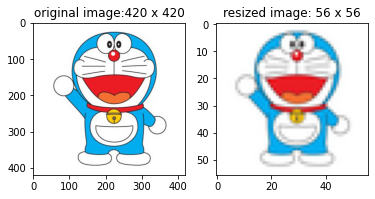

In [3]:
path=os.getenv("HOME") + "/aiffel/rock_scissor_paper/dora.jpg" # jpg파일의 경로
img=Image.open(path)     # img에 이미지 파일을 불러온다.
resize=img.resize((56,56),Image.ANTIALIAS)  # 이미지를 48 x 48으로 줄인다. 
img_to_numpy=np.array(img)  # numpy의 array를 사용하여 이미지 파일을 numpy 배열로 만든다.

plt.Figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img)    # matplotlib의 imshow메서드를 사용하여 이미지를 출력한다.
plt.title("original image:%d x %d"%img.size)

plt.subplot(1,2,2)
plt.imshow(resize)
plt.title("resized image: %d x %d"%resize.size)

print("PILOW 파일을 numpy 로 만든다.:")
print(img_to_numpy[0])

#### numpy 라이브러리의 np.zeros(), np.reshape()
- __numpy.zeros(shape, dtype=float)__ : dtype에서 정한 자료형으로 이루어진 0이 shape의 배열로 이룬다.  
- __numpy.reshape(a, newshape) 혹은 a.reshape(newshape)__ : 수정할 배열 a를 newshape의 배열로 바꿔준다. 
----------------

- numpy의 shape는 차원에 따라 다음과 같이 달라진다.  
__A:__ (channels,rows,columns)의 개수/ __channels__: 2차원 행렬(rows,columns)의 개수/ __rows:__ 행의 개수/ __columns:__ 열의 개수  
__1차원__: np.zeros(크기)  
__2차원__: np.zeros((rows , columns))  
__3차원__: np.zeros((channels,rows,columns))  
__4차원__: np.zeros((A,channels,rows,columns))  

-----------------------------

- 뒤에서 load_data() 함수에서 np.zeros()로 0으로 이루어진 1차원 배열을 만들고, reshape로 학습하기 위한 배열의 형태로 바꿔줄 것이다. 그때 numpy의 4차원 배열로 만들어서 이미지 값을 하나씩 입력할 것이다.

In [4]:
np.zeros(4) # 1차원

array([0., 0., 0., 0.])

In [5]:
np.zeros((3,4)) # 2차원 (행,열)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [6]:
np.zeros((2,3,4)) # 3차원 (채널,행,열)

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]])

In [7]:
np.zeros((2,2,3,4)) # 3차원 (A,채널,행,열)/ A는 (채널, 행, 열)의 개수

array([[[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]],


       [[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]]])

#### resize_images(img_path): 이미지 데이터를 작은 사이즈로 변환
- 이미지244 x 244 이미지를 그대로 학습을 하면 연산량이 많기 때문에 시간과 컴퓨팅 파워를 줄이기 위해서 이미지를 50 x 50 로 줄였다. 
- 이 과정에서 glob라이브러리의 glob 함수와 PIL라이브러리의 Image 클래스의 open, resize, save 메서드를 사용하였다.

In [30]:
def resize_images(img_path): # img_path를 resize_images 함수에 입력하면
    images=glob.glob(img_path + "/*.jpg")  
    # *(asterisk:애스터리스트)는 문자열 검색시 모든 것이라는 뜻으로 
    #"/*.jpg"라는 의미는 디렉터리 아래에 .jpg로 끝나는 모든 문자열. 즉 jpg파일을 반환하라는 뜻이다.
    
    print(len(images), " images to be resized.")

    target_size=(56,56)     # 바꾸고자 하는 이미지 크기
    for img in images:      
        old_img=Image.open(img)     # img 경로의 이미지를 numpy 배열 형태로 변수 old_img에 반환 시킨다.
        new_img=old_img.resize(target_size,Image.ANTIALIAS)   #old_img에 있는 이미지를 target_size로 축소 시킨다, 
                                                              #ANTIALIAS 방법으로 이미지 깨지는 것을 막아준다.
        new_img.save(img, "JPEG")   # 다시 img 경로에 축소된 이미지를 JPEG파일로 저장한다.
    
    print(len(images), " images resized.")
    return len(images)     # img_path에 저장된 jpg 이미지 파일이 몇장인지 반환한다. 
                            # road_data 함수의 number_of_data에 입력시키려고 반환하게 하였다.

#### load_data(img_path, number_of_data=300,datatype="train"): 이미지 데이터를 numpy 배열로 변환
- img_path의 이미지 파일들을 딥러닝 학습을 시키기 위해서 numpy 배열로 바꿔준다.  
- 이 코드는 feature(이미지 데이터)와 target (label,레이블)이 담길 영행렬을 각각 만들고, 영행렬에 이미지 데이터와 레이블을 차례대로 입력하는 코드이다.  
||step|설명|코드|
|-|----|:----|:----|
|영행렬 만들기|step1|(설명변수,features) 크기가 17498880(2160 x 56 x 56 x 3)인 1차원 영행렬(데이터 타입이 np.int32인 0인)을 만든다.|imgs=np.zeros( number_of_data* img_size * img_size * color, dtype=np.int32)|
|영행렬 만들기|step2|(설명변수,features) step1에서 만든 영행렬을 (number_of_data,img_size,img_size,color)의 영행렬로 바꾼다|imgs=imgs.reshape(number_of_data,img_size,img_size,color)|
|영행렬 만들기|step3|(레이블,target) 크기가 number_of_data인 1차원 영행렬(데이터 타입이 np.int32인 0인)을 만든다.|labels=np.zeros(number_of_data,dtype=np.int32)|
|영행렬에 입력|step4|step1~3 과정에서 만들어진 영행렬에 각 클래스 별로 저장한 이미지 데이터와 레이블을 idx_인덱스 별로 차례대로 입력한다.|아래의 load_data 함수 참조|

--------------------------------------------------------------

다음 셀의 코드는 load_data 함수의 데이터를 담을 배열이 될 영행렬을 만드는 코드이다.

In [9]:
number_of_data,img_size,color=2160,56,3 # 함수 안에서 만들어질 영행렬을 정리해보자
imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32) # 1차원 0행렬의 크기
print(imgs[:5],"np.zeros로 만들어진 1차원 영행렬 imgs의 크기:",imgs.shape)
print("-------------------------------------------------------")

imgs=imgs.reshape(number_of_data,img_size,img_size,color)
print("배열의 모양을 바꾼후 img 배열의 0번 인덱스의 배열 크기",imgs[0,:,:,:].shape,"/ img 배열의 전체 크기:",imgs.shape)
print("-------------------------------------------------------")
labels=np.zeros(number_of_data,dtype=np.int32)
print("label의 전체 크기:",labels.shape)

[0 0 0 0 0] np.zeros로 만들어진 1차원 영행렬 imgs의 크기: (17498880,)
-------------------------------------------------------
배열의 모양을 바꾼후 img 배열의 0번 인덱스의 배열 크기 (56, 56, 3) / img 배열의 전체 크기: (1860, 56, 56, 3)
-------------------------------------------------------
label의 전체 크기: (1860,)


이처럼 0으로 채워진 img배열을 만든 후에 이미지를 하나씩 불러와서 데이터를 이 영행렬에 입력한다.  
배열의 모양을 바꾼 img 배열의 0번 인덱스의 배열(__img \[0,:,:,: \]__)의 크기는 __56(img_size)x56(img_size)x3(color)인 이미지를 numpy 배열의 사이즈와 같다__ 는 것을 알수 있다.  그래서 for반복문을 사용해서

첫번째 불러온 이미지를 img[0,:,:,:]에 입력하고,  
두번째 불러온 이미지를 img[1,:,:,:]에 입력하고...  

idx번째 불러온 이미지를 img[idx,:,:,:]에 입력을 한다. 이렇게 설명변수에 이미지를 입력하는 동안 label에 해당 클래스의 레이블을 입력한다.

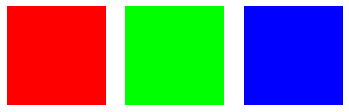

In [10]:
plt.Figure(figsize=(10,10))
imgs[0,:,:,0]=255 # 가장 오른쪽의 인덱스가 color/ 0이 Red
plt.subplot(1,3,1)
plt.imshow(imgs[0])
plt.axis('off')

imgs[1,:,:,1]=255 # 가장 오른쪽의 인덱스가 color/ 1이 green
plt.subplot(1,3,2)
plt.imshow(imgs[1])
plt.axis('off')

imgs[2,:,:,2]=255 # 가장 오른쪽의 인덱스가 color / 1이 blue
plt.subplot(1,3,3)
plt.imshow(imgs[2])
plt.axis('off')


plt.show()

In [11]:
imgs[0,:3,:3,:]#red가 보여지는 imgs의 0번 인덱스의 일부를 보자. 

array([[[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]]], dtype=int32)

In [12]:
def load_data(img_path, number_of_data=300,datatype="train"):  # 가위바위보 이미지 개수 총합에 주의
    # img_path 안에 있는 scissor, rock, paper 폴더의 이미지를 학습하기 위해서 numpy 배열에 저장한다. 
    
    img_size=56
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32)
    imgs=imgs.reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'): # iglob를 사용하여 scissor 폴더 안에 있는 jpg 파일을 제너레이터로 가져온다.
        img = np.array(Image.open(file),dtype=np.int32) # 이미지 데이터를 불러와서 numpy 배열로 바꿔서 변수 img에 할당한다.
        imgs[idx,:,:,:]=img    # 영행렬 imgs의 idx번째 인덱스에 이미지 배열을 저장
        labels[idx]=0   # 영행렬labels의 idx번째 인덱스에 가위의 라벨인 0을 입력
        idx=idx+1       # idx 하나 증가해서 다음 이미지는 idx+1번째 인덱스에 저장한다.

    for file in glob.iglob(img_path+'/rock/*.jpg'): # 바위에 대해서 가위의 코드와 동일하게 수행
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'): # 보에 대해서 가위의 코드와 동일하게 수행
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    
        labels[idx]=2   # 보 : 2
        idx=idx+1
    if datatype=="train": # 학습데이터인지 시험데이터 인지에 따라 출력되는 문구가 다르다.
        print("학습 데이터(x_train)의 이미지 개수는", idx,"입니다.")
    else:
        print("시험 데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels



In [102]:
#  train dataset 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서 사이즈 조절을 한다.
train_numbers={"scissor":0,"paper":0,"rock":0} # 학습되는 레이블 각각의 이미지의 갯수를 딕셔너리에 저장한다.

# train데이터셋의 이미지 축소
for i in train_numbers:# "scissor","paper","rock" 차례대로 출력
    image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/{0}".format(i) # 가위, 바위, 보 이미지 디렉터리 path
    train_numbers[i]=resize_images(image_dir_path)   # resize_images로 이미지 사이즈를 줄이고, 각 클래스 별 이미지를 저장한다.

# test 데이터셋 이미지 축소
test_numbers={"scissor":0,"paper":0,"rock":0}
for i in test_numbers:
    image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/{0}".format(i)
    test_numbers[i]=resize_images(image_dir_path)

# 이미지를 numpy행렬에 
image_dir_path = os.getenv("HOME") + '/aiffel/rock_scissor_paper'
(x_train, y_train)=load_data(image_dir_path,number_of_data=sum(train_numbers.values())) 
                                                                # train_number에 저장된 이미지의 개수를 number_of_data에 입력

image_dir_path = os.getenv("HOME") + '/aiffel/rock_scissor_paper/test'
(x_test, y_test)=load_data(image_dir_path,number_of_data=sum(test_numbers.values()),datatype="test") # 


720  images to be resized.
720  images resized.
720  images to be resized.
720  images resized.
720  images to be resized.
720  images resized.
150  images to be resized.
150  images resized.
150  images to be resized.
150  images resized.
150  images to be resized.
150  images resized.
학습 데이터(x_train)의 이미지 개수는 2160 입니다.
시험 데이터(x_test)의 이미지 개수는 450 입니다.


학습 데이터의 설명변수(feature)는  x_train에 저장되고, 레이블(label/target)은 y_train에 저장된다.  
시험 데이터의 설명변수(feature)는  x_test에 저장되고, 레이블(label/target)은 y_test에 저장된다.  

-------------------------------------------------------------------

### 2. 모델 구성, 하이퍼 파라미터 튜닝 및 평가

#### 데이터 정규화 (Normalizing)

딥러닝은 설명변수 간의 스케일 차이가 많이 난다면 설명변수의 스케일이 큰 데이터의 feature가 학습에 많이 영향을 미치게 되어서 학습이 불균형적으로 이뤄지게 된다. 그래서 데이터의 스케일을 비슷한 구간으로 맞춰주는 과정이 꼭 필요하다. 이미지 데이터의 경우는 RGB 채널별로 가장 밝으면 255, 가장 어두우면 0이다. 그래서 __이미지 데이터가 담긴 배열을 255.0으로 나누어서 0~1사이의 값 을 갖도록 정규화__ 시켜준다.

In [103]:
x_train_norm = x_train/255.0   # normalizing
x_test_norm = x_test/255.0   # normalizing

In [104]:
print(x_train_norm.max(), x_train_norm.min()) 
print(x_test_norm.max(), x_test_norm.min()) # 학습데이터셋과 테스트 데이터셋의 최대값은 1이하, 최소값은 0이상임을 알수 있다.

1.0 0.0
1.0 0.0


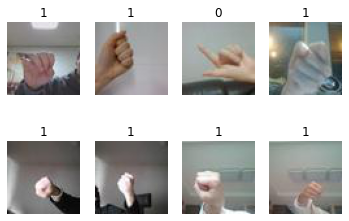

In [105]:
# 학습데이터의 일부를 출력해보자.
np.random.seed(10)
plt.Figure(figsize=(4,20))
for i in range(8):
    n=np.random.randint(1860)
    plt.subplot(2, 4, i+1)
    plt.imshow(x_train_norm[n])
    plt.axis('off')
    plt.title("%d"%y_train[n])
plt.show()

In [106]:
x_train_reshaped=x_train_norm.reshape( -1, 56, 56, 3)  
x_test_reshaped=x_test_norm.reshape( -1, 56, 56, 3)
                                 # reshape의 50,50,3 모양은 유지 시킨채로 첫번째 값인 -1은 알아서 값을 계산해서 입력하라는 뜻이다.

print(x_train_reshaped.shape, y_train.shape)

(2160, 56, 56, 3) (2160,)


### 베이스 모델 설명

- exploration에서 제시되었던 LeNet 모델을 베이스 모델로 사용하였다. LeNet은 최초의CNN(convolutional Neural Network)이다.
- 1989년 Yann LeCun은 미국의 우편번호를 딥러닝을 이용하여 분류하고자 했다. MNIST데이터셋을 만들고 Yann LeCun이 CNN알고리즘으로 LeNet을 내놓았다. 이 모델을 예시로 배웠고 예시로 배웠던 이 모델을 베이스 모델로 삼아서 최적화를 하고자한다.

베이스모델은 
    step1.합성곱 레이어에서 합성곱을 한 feature map들을 만들어낸다.
    step2.feature map들을 Maxpooling을 하여서 출력해낸다.
    step3.이 값을 다시 1-2과정을 한다.(단, filter 사이즈를 달리하고, 1은 이미지 데이터가 입력되는 층이기 때문에 데이터 사이즈가 이미지 데이커 크기이다. 3번은 2에서 연산된 값이 입력된다는 점에서 다르다.)
    step4. 은닉층에 학습시키고 flatten을 하여서 soft max(클래스3개를 분류하는 다중분류 문제이기 때문에 soft max 사용)로 입력된 데이터가 어떤 클래스일지 예측하고, cross entropy로 예측한 클래스를 실제 클래스의 loss를 계산해낸다. 그리고 거꾸로 backpropagation을 해서 그레디언트를 계산하여 filter들의 가중치를 학습시킨다.

----------------------------------------------

- step1. 합성곱 연산을 이용해서 각각의 요소를 서로 곱해서 더한 값(하나의 값)이 출력이 된다.(아래 그림 참조)
    ![](https://blog.kakaocdn.net/dn/Ck3Fe/btrci8l9TUb/WR6FUM4tzhQp8KHW4SKFZ0/img.png)

- 이렇게 필터가 입력된 이미지를 한픽셀씩 이동하여서 합성곱을 한다. 이 과정에서 filter 하나당 하나의 feature map을 만들어낸다. filter 하나가 이미지 패턴을 잡아내어 feature를 하나 만들어내는 역할을 하기 때문에 이미지의 디테일한 특징을 더 많이 잡아내려면 filter 개수를 늘리고 커널 사이즈를 디테일하게 조절할 필요가 있다.(아래의 움직이는 이미지 참조)
- 이 과정을 케라스는 Conv2D를 사용하여 구성한다. 여기에 필터의 개수와 필터 사이즈 그리고 만일 입력층이라면 입력데이터의 모양을 입력한다.

![](https://miro.medium.com/max/803/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif)


- step2. 합성곱 레이어를 나온 값들을 max pooling의 커널 사이즈만큼 나눠서 각각 가장 큰 값을 반환한다. 
![](https://production-media.paperswithcode.com/methods/MaxpoolSample2.png)
- step3. 또 다시 Conv2D, Max pooling 레이어를 거친다.
- step4. 입력된 값을 flatten을 하여서 쭉 늘린 후에 Dense레이어를 통해 은닉층으로 학습한 뒤 soft max로 분류하고 cross entropy를 통해 학습 loss를 계산한 다음 

In [18]:
def base_model(n_channel_1, n_channel_2, n_dense, n_train_epoch):

    model=keras.models.Sequential() # 시퀀스형 
    model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation="relu", input_shape=(56,56,3))) 
    model.add(keras.layers.MaxPool2D(2,2))
    model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(n_dense, activation='relu'))
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.summary()
    model.compile(optimizer="adam",
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    # 모델 훈련
    history=model.fit(x_train_reshaped, y_train, validation_data=(x_test_reshaped, y_test), epochs=n_train_epoch)
    # 모델 시험
    return history


### 베이스라인

In [24]:
n_channel_1=10
n_channel_2=32
n_dense=32
n_train_epoch=50

model=base_model(n_channel_1, n_channel_2, n_dense, n_train_epoch)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 54, 54, 10)        280       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 27, 27, 10)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 25, 25, 32)        2912      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                147488    
_________________________________________________________________
dense_11 (Dense)             (None, 3)                

Text(0.5, 1.0, 'base model accuracy')

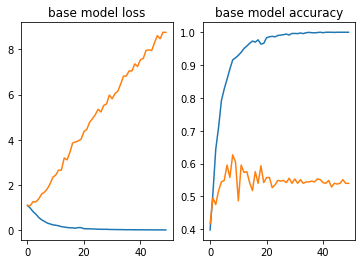

In [25]:
# 기본 베이스라인이었을때 test 데이터셋과 train 데이터셋의 accuracy와 loss

base_m=pd.DataFrame(model.history)
plt.Figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(base_m[["loss","val_loss"]])
plt.title("base model loss")

plt.subplot(1,2,2)
plt.plot(base_m[["accuracy","val_accuracy"]])
plt.title("base model accuracy")


In [26]:
base_m.max()

loss            1.091340
accuracy        1.000000
val_loss        8.759213
val_accuracy    0.626667
dtype: float64

base model accuracy와 같이epoch가 지남에 따라 학습 데이터셋의 성능은 올라가지만 시험데이터셋의 성능은 떨어진 것을 알수 있다. 즉, overfitting이 되었다. 

그래서 학습데이터셋에 지나치게 학습되는 것을 막기 위해서 최적화 기법으로 Batchnormalization과 dropout, mini batch gredient를 사용했다.activation 함수를 거치기 직전에 BatchNormalization, 그리고 softmax를 거치기 전에 Dropout을 적용하였다.


### 모델 최적화를 위한 방법
- Dropout: 신경망에서 과대적합을 줄이는 방법중 하나로 무작위로 일부 뉴런을 비활성화시킨다. 무작위로 일부 뉴런을 비활성화시키면 특정 뉴런에 과도하게 의존해서 학습되는 것을 막아줘서 오버피팅을 막아준다. 보통 softmax를 거치기 전에 dropout을 적용한다.
- Batch normalization: 레이어 단계마다 출력되는 값들을 정규화 시켜주는 방법이다. 보통 활성화함수를 거치기 전에 정규화를 시켜준다. 논란이 많은 방법이긴 하지만 성능이 개선되기는 한다.

In [27]:
# model1은 BatchNormalization과 dropout을 적용


def model1(n_channel_1, n_channel_2, n_dense, dropout_rate,n_train_epoch,batch_size,lr):
    model=keras.models.Sequential()
    model.add(keras.layers.Conv2D(n_channel_1, (3,3), input_shape=(56,56,3)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPool2D(2,2))

    model.add(keras.layers.Conv2D(n_channel_2, (3,3)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation("relu"))

    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(n_dense, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history=model.fit(x_train_reshaped, y_train, validation_data=(x_test_reshaped, y_test), epochs=n_train_epoch, batch_size=batch_size)

    return history



하이퍼파라미터 평가 및 방법
- 다소 무식한 방법이지만 3중 for 반복문을 사용하여서 학습에서 가장 중요한 학습율(learning rate)와 드롭아웃 비율(dropout rate) 그리고 배치사이즈(batch size)의 가장 좋은 조합을 찾고자 했다

In [29]:
n_channel_1=10
n_channel_2=32
n_dense=32
n_train_epoch=50
dropout_rate=[i*0.1 for i in range(3,10)]
lrs=[0.01,0.001]
batch_size=[2**i for i in range(4,7)]

acc={}
for i in lrs:
    for j in batch_size:
        for k in dropout_rate:
            history=model1(n_channel_1, n_channel_2, n_dense, i,n_train_epoch,j,i)
            acc[f"{i}-{j}-{k}"]=history

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 54, 54, 10)        280       
_________________________________________________________________
batch_normalization_10 (Batc (None, 54, 54, 10)        40        
_________________________________________________________________
activation_10 (Activation)   (None, 54, 54, 10)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 27, 27, 10)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 25, 25, 32)        2912      
_________________________________________________________________
batch_normalization_11 (Batc (None, 25, 25, 32)        128       
_________________________________________________________________
activation_11 (Activation)   (None, 25, 25, 32)       

In [68]:
def find_acc(acc, key,hp):
    hp1,hp2,hp3=key.split("-")
    dd=pd.DataFrame(acc[key].history)
    return {hp[0]:hp1,hp[1]:hp2,hp[2]:hp3,"acc":dd.max()[3]}

dict_list=[]
for i in acc.keys():
    dict_list.append(find_acc(acc,i,("lr","BS","dropout")))
    
acc_df=pd.DataFrame(dict_list) # 가장 높은 accuracy는 0.574667
acc_df.loc[acc_df["acc"]>0.626667].sort_values("acc", ascending=False) 

,lr,BS,dropout,acc
26,0.001,16,0.8,0.664444
27,0.001,16,0.9,0.628889


베이스 모델에서 최고 성능보다 높은 성능을 보인 하이퍼 파라미터 조합은 2개가 나왔다.

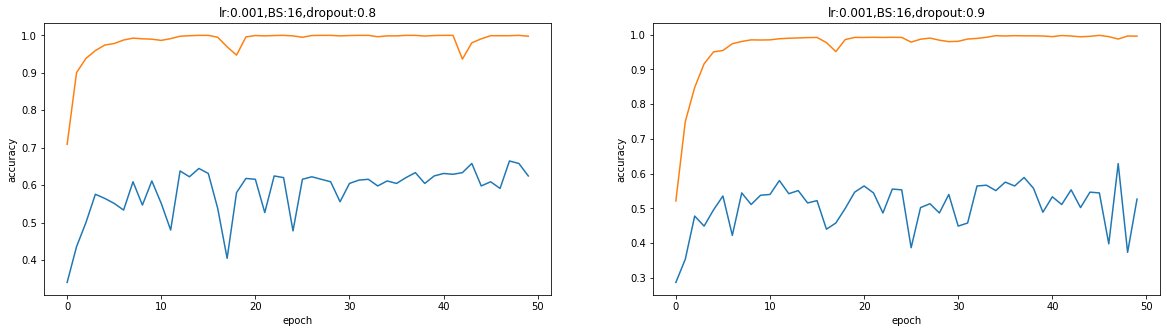

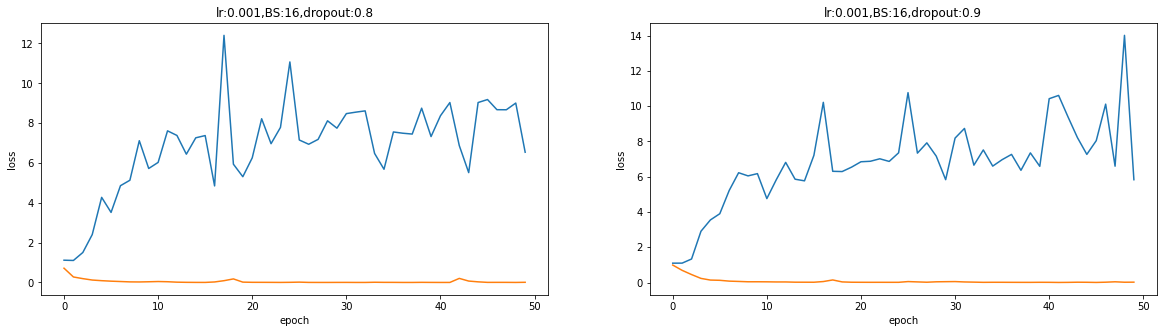

In [59]:
first=pd.DataFrame(acc["0.001-16-0.8"].history)
second=pd.DataFrame(acc["0.001-16-0.9"].history)


plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(first["val_accuracy"])
plt.plot(first["accuracy"])
plt.title("lr:0.001,BS:16,dropout:0.8")
plt.xlabel("epoch")
plt.ylabel("accuracy")

plt.subplot(122)
plt.plot(second["val_accuracy"])
plt.plot(second["accuracy"])
plt.title("lr:0.001,BS:16,dropout:0.9")
plt.xlabel("epoch")
plt.ylabel("accuracy")


plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(first["val_loss"])
plt.plot(first["loss"])
plt.title("lr:0.001,BS:16,dropout:0.8")
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(122)
plt.plot(second["val_loss"])
plt.plot(second["loss"])
plt.title("lr:0.001,BS:16,dropout:0.9")
plt.xlabel("epoch")
plt.ylabel("loss")

plt.show()

최고 accuracy가 가장 좋게나왔던 learning rate, batch size, dropout rate의 조합의 train과 test의 accuracy가 epoch가 증가함에 따라서 어떻게 변하는지 그래프를 그려보았다. 
- 학습 데이터셋이 안정적으로 학습이 되는 것을 볼수 있고 학습 데이터가 안정적으로 학습이 되어가면서 시험데이터셋(test dataset)의 성능이 매우 떨어지는 것을 볼 수 있었다. 
- 신기하게도 둘다 학습률(learning rate)를 0.001, 배치 사이즈(batch size)를 16이고 드롭아웃 시키는 비율이 0.9와 0.8이었다.
- 오버피팅을 방지하기 위해서 batch normalization과 mini batch gredient descent, drop out을 시도하였고 학습률에도 변화를 주어보았다. 그럼에도 불구하고 오버피팅의 문제가 해결이 되지는 않았지만, 최소한 베이스 모델보다는 accuracy가 0.04 0.002 올라간 것을 확인 할 수 있었다. 

다음 단계에서는 모델의 정확도를 올라갔던 하이퍼파라미터의 조합으로 2개의 2차원 컨볼루션 레이어의 필터의 개수와 마지막 max pooling을 거친 다음 히든레이어로 fully connetion되는 레이어의 출력노드를 튜닝해보았다.

In [54]:
n_channel_1=[3*i for i in range(6,12)]
n_channel_2=[2*i for i in range(4,7)]
n_dense=[2**i for i in range(5,9)]

n_train_epoch=100
dropout_rate=0.8
lrs=0.001
batch_size=16

acc_2={}
for i in n_channel_1:
    for j in n_channel_2:
        for k in n_dense: #n_channel_1, n_channel_2, n_dense, dropout_rate,n_train_epoch,batch_size,lr
            history=model1(i, j, k, dropout_rate,n_train_epoch,batch_size,lrs)
            acc_2[f"{i}-{j}-{k}"]=history

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 54, 54, 18)        504       
_________________________________________________________________
batch_normalization_98 (Batc (None, 54, 54, 18)        72        
_________________________________________________________________
activation_98 (Activation)   (None, 54, 54, 18)        0         
_________________________________________________________________
max_pooling2d_102 (MaxPoolin (None, 27, 27, 18)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 25, 25, 8)         1304      
_________________________________________________________________
batch_normalization_99 (Batc (None, 25, 25, 8)         32        
_________________________________________________________________
activation_99 (Activation)   (None, 25, 25, 8)       

In [69]:
dict_list=[]
for i in acc_2.keys():
    dict_list.append(find_acc(acc_2,i,("n_ch_1","n_ch_2","n_dense")))
    
acc2_df=pd.DataFrame(dict_list) 
acc2_df.loc[acc2_df["acc"]>0.664444].sort_values("acc", ascending=False) 

,n_ch_1,n_ch_2,n_dense,acc
49,30,8,64,0.704444
67,33,10,256,0.702222
15,21,8,256,0.686667
35,24,12,256,0.682222
36,27,8,32,0.675556
26,24,8,128,0.671111
66,33,10,128,0.668889
53,30,10,64,0.664444


learning rate와 dropout 비율, 배치사이즈를 튜닝한 모델의 최고 성능인 0.664444 비해 최대 0.04가량 accuracy가 올라간 것을 확인 할수 있었다. 사실 처음에 맞추었던 filter의 개수와 은닉층의 노드수는 mnist를 분류할때 사용했던 값들이었다. 그러니까 숫자에 비해 이미지의 디테일이 많은 손 이미지를 학습하기에는 필터의 개수가 부족했던 것이다.  

일단 딥러닝 학습에 핵심이 되는 학습율과 배치사이즈를 조절하는 것이 모델의 성능을 판단하는데 중요할 것으로 예상되어 먼저 튜닝을 하였고 이렇게 튜닝한 값이 베이스모델보다 성능이 좋은 정확도들이 __학습율 0.001, 배치 사이즈 16 그리고 dropout 0.8 부근__ 으로 수렴을 한 것을 볼 수 있었다.  

- 그래서 이 값을 기준으로 필터의 수와 은닉층의 출력 노드 수를 조절하니까 accuracy가 위에 보는 것처럼 개선이 된 것을 볼 수 있었다.
- 다음은 가장 성능이 좋았던 두개의 조합의 loss와 accuracy를 그래프로 그려보았다.

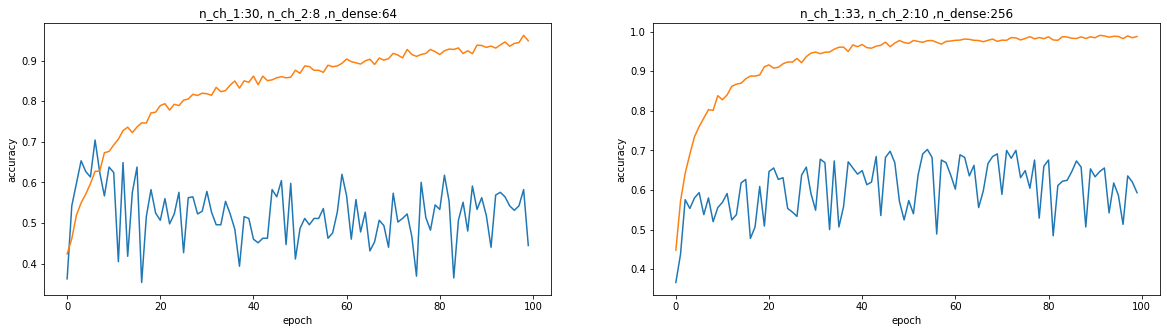

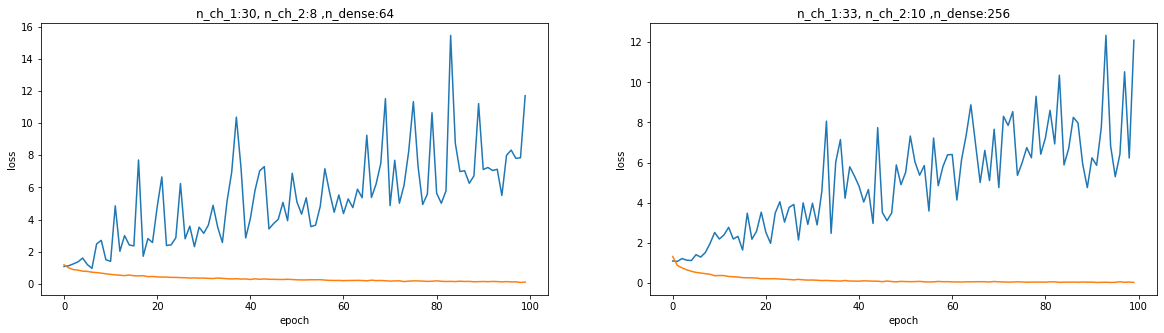

In [73]:
first=pd.DataFrame(acc_2["30-8-64"].history)
second=pd.DataFrame(acc_2["33-10-256"].history)


plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(first["val_accuracy"])
plt.plot(first["accuracy"])
plt.title("n_ch_1:30, n_ch_2:8 ,n_dense:64")
plt.xlabel("epoch")
plt.ylabel("accuracy")

plt.subplot(122)
plt.plot(second["val_accuracy"])
plt.plot(second["accuracy"])
plt.title("n_ch_1:33, n_ch_2:10 ,n_dense:256")
plt.xlabel("epoch")
plt.ylabel("accuracy")


plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(first["val_loss"])
plt.plot(first["loss"])
plt.title("n_ch_1:30, n_ch_2:8 ,n_dense:64")
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(122)
plt.plot(second["val_loss"])
plt.plot(second["loss"])
plt.title("n_ch_1:33, n_ch_2:10 ,n_dense:256")
plt.xlabel("epoch")
plt.ylabel("loss")

plt.show()

- 베이스 모델의 오버피팅이 심해서 dropout, batch normalization을 적용하고, learning rate, batch size, dropout rate를 튜닝하였으나 오버피팅이 생각만큼 개선되지 않은 것이 다소 실망스러웠으나 그 중에 가장 좋은 하이퍼파라미터 값으로 나머지 하이퍼파라미터 값을 튜닝해보니 그래도 베이스 모델보다는 오버피팅이 개선된 것을 볼 수 있었다. 
- 다만 테스트 데이터셋의 이미지가 상대적으로 적고, 다양성이 충분하지 않아서 loss와 accuracy가 안정적이지 못한 것이 아쉽다  

두 그래프의 왼쪽 모델은 epoch가 6일때 가장 좋은 성능이 나왔고, 오른쪽의 모델은 epoch이 54일때 가장 좋은 성능이 나왔다. 즉 학습을 오래 시킨다고 능사가 아님을 알수 있었다. 학습을 오래 시키면 시킬수록 오히려 성능이 떨어지게 된다는 것을 알 수 있었다.

In [98]:
f=pd.DataFrame(acc_2["30-8-64"].history)
f.loc[f["val_accuracy"]>0.7]

,loss,accuracy,val_loss,val_accuracy
6,0.728841,0.627315,0.966513,0.704444


### 사실 이 과제를 내기 전에 하나의 에피소드가 있었다.

- exploration01을 하고 난후 exploration02를 마친 뒤에 이 과제를 시작을 해서 당연하게 validation을 해야한다고 생각하고 다음과 같이 학습데이터셋에서 validation 데이터를 분리해낸 다음 결과를 보니까 다음과 같은 결과가 나왔다. 

In [107]:
x_train, x_val, y_train, y_val= train_test_split(x_train_reshaped, y_train, stratify=y_train, test_size=0.2, random_state=42)


In [108]:

def re_model(n_channel_1, n_channel_2, n_dense, n_train_epoch):

    model=keras.models.Sequential() # 시퀀스형 
    model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation="relu", input_shape=(56,56,3))) 
    model.add(keras.layers.MaxPool2D(2,2))
    model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(n_dense, activation='relu'))
    model.add(keras.layers.Dense(3, activation='softmax'))
    model.summary()
    model.compile(optimizer="adam",
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    # 모델 훈련
    history=model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=n_train_epoch)
    # 모델 시험
    return model


In [109]:
n_channel_1=10
n_channel_2=32
n_dense=32
n_train_epoch=50

model_=re_model(n_channel_1, n_channel_2, n_dense, n_train_epoch)

Model: "sequential_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_250 (Conv2D)          (None, 54, 54, 10)        280       
_________________________________________________________________
max_pooling2d_250 (MaxPoolin (None, 27, 27, 10)        0         
_________________________________________________________________
conv2d_251 (Conv2D)          (None, 25, 25, 32)        2912      
_________________________________________________________________
max_pooling2d_251 (MaxPoolin (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_125 (Flatten)        (None, 4608)              0         
_________________________________________________________________
dense_250 (Dense)            (None, 32)                147488    
_________________________________________________________________
dense_251 (Dense)            (None, 3)              

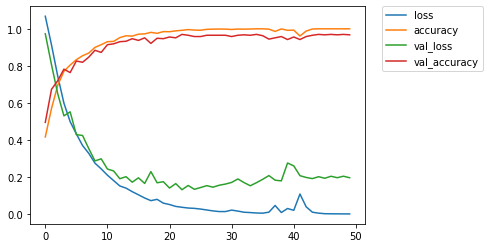

In [110]:
pd.DataFrame(model_.history.history).plot()
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.)
plt.show()

In [112]:
model_.evaluate(x_test_reshaped, y_test) 

15/15 [==============================] - 0s 2ms/step - loss: 12.3820 - accuracy: 0.5556


[12.381986618041992, 0.5555555820465088]

__결과__ 적으로 validation set의 성능은 매우 높아서 그대로 테스트 데이터셋에 성능을 비교해보니 0.55의 정확도를 갖는 것을 확인했다. 

검증데이터셋(validation dataset)이 학습데이터셋에서 나오다보니 같은 사람의 손으로 학습을 해서 같은 사람의 손으로 검증을 하게 되었다. 그래서 베이스모델에서 더 이상 수정할 필요가 없이 성능이 잘 나온 것을 판단된다. 그래서 학습데이터와 다른 이미지인 테스트 데이터셋의 예측성능이 떨어지게 된 것으로 판단된다.  

일단 이번 과제를 통해서 __하이퍼파라미터 튜닝__ 을 하여서 모델 성능을 개선 시키는 경험을 하고자 했던 목표가 있었기 때문에 어쩔수 없이 테스트 데이터셋으로 튜닝을 진행했다. 


----------------------------------------------------------
### 3. 회고

0. 그 전에 회사에서 데이터를 수집하고 레이블링하는 업무가 주가 되었다.  직접 딥러닝 모델을 구성하고 튜닝하는 것을 경험하고 싶었지만 어디에서 시작해야할지 엄두를 못내고 있다가 아이펠에서 처음으로 딥러닝 모델을 전반적으로 구성하는 경험이었기에 앞으로의 동기부여가 될 경험이라고 생각했다.

1. 결과적으로 베이스모델이 0.6 정도의 성능을 보였었는데 다양한 최적화 방법을 사용해서 오버피팅을 방지하여 __성능이 0.7__ 으로 높여보는 경험을 해본 것은 좋았다. 하지만 앞으로 딥러닝 모델을 만들기 위해서는 가급적이면 많은 양의 데이터를 다양하게 수집을 해서 이렇게 검증데이터셋만으로도 모델 튜닝을 할수 있는 환경을 조성하는게 좋은 모델을 만드는데 첫걸음이라는 것을 느꼈다.

2. 그리고 모델의 구조를 만드는데 좀 더 중요하다고 생각되어진 학습률, 배치사이즈, 드롭아웃 비율을 튜닝했는데 생각보다 성능이 많이 개선되지 않아서 실망했었지만, 그 중에서도 가장 좋은 것을 갖고 다시 다른 하이퍼파라미터들을 튜닝을 시도한 결과 모델 성능이 개선되는 경험에서 희열이 느껴졌다. 딥러닝 모델은 하이퍼파라미터를 미세하게 조정하는데서 모델성능이 좌우된다는 말은 들어봤지만 실제로 미묘한 차이로 성능이 개선되는 것을 보면서 개념적으로만 이해하고 있던 손실함수가 실체적으로 느껴졌다.
3. 구불구불 하게 있는데 여러가지 하이퍼파라미터들을 조합하면서 손실이 가장 낮은 지점을 찾아가는 것 같았다.
4. 그리고 일단 과제를 하기 위해서 빠르게 코드를 짜느라고 기존에 익숙했던 코드 방식으로 절차적 프로그래밍 중심으로 코드를 구성했는데 앞으로는 클래스로 이 일련의 과정을 축약할 수 있는 방법을 고민해봐야겠다는 생각을 했다. 반복되는 코드들이 많아서 앞으로 프로젝트를 하면서 유용하게 쓰일 것 같은 코드들이 일종의 자산이 될 것 같다.